In [1]:
import ugradio
import numpy as np
import pandas as pd
from astropy.io import fits
import matplotlib.pyplot as plt
import dish
import cartopy.crs as ccrs
from scipy.interpolate import interp2d
from tqdm import tqdm, trange
%matplotlib inline
from astropy.coordinates import SkyCoord
from astropy import constants as c
import astropy.units as u

No module named 'rtlsdr'


In [2]:
def calibrate(data_nd0, data_nd1, pol):
    diff = np.array(data_nd1) - np.array(data_nd0)
    if pol == 0:
        T = 90
    elif pol == 1:
        T = 65
    else: print('Bruh its literally either a 0 or 1 you cant fuck it up')
    G = T/diff
    t_line = G * data_nd0
    return t_line

def calibrate1(data_nd0, data_nd1, pol):
    diff = np.median(np.array(data_nd1) - np.array(data_nd0))
    if pol == 0:
        T = 90
    elif pol == 1:
        T = 65
    else: print('Bruh its literally either a 0 or 1 you cant fuck it up')
    G = T/diff
    t_line = G * data_nd0
    return t_line

def calibrate2(data_nd0, data_nd1, pol):
    
    F_low = 146.5
    F_high = 148.5
    freq = np.linspace(144,156,8192)
    condition = (freq >= F_low) * (freq <= F_high)
    trunc_freq = freq[condition]
    
    diff = np.median(np.array(data_nd1[:,condition]) - np.array(data_nd0[:,condition]))
    
    if pol == 0:
        T = 90
    elif pol == 1:
        T = 65
    else: print('Bruh its literally either a 0 or 1 you cant fuck it up')
        
    G = T/diff
    t_line = G * data_nd0
    return t_line

In [3]:
nfiles = 697
nfreq = 8192

In [4]:
nspec = 50

list_0 = np.empty((nfiles, nspec, nfreq))
# list_1 = np.empty((nfiles, nspec, nfreq))

for i in trange(nfiles):
    
    f = fits.open(f'lab4_data/{i}_nd0.fits')
    
    for j in range(nspec):
        
        list_0[i,j] = f[j+1].data['auto0_real']
        
#         list_1[i,j] = f[j+1].data['auto1_real']

100%|██████████| 697/697 [02:24<00:00,  4.83it/s]


In [5]:
noise_spec = 5

noise_0 = np.empty((nfiles, noise_spec, nfreq))
# noise_1 = np.empty((nfiles, noise_spec, nfreq))

for i in trange(nfiles):
    
    f = fits.open(f'lab4_data/{i}_nd1.fits')
    
    for j in range(noise_spec):
        
        noise_0[i,j] = f[j+1].data['auto0_real']
        
#         noise_1[i,j] = f[j+1].data['auto1_real']

100%|██████████| 697/697 [00:15<00:00, 45.10it/s]


In [6]:
median_specs_0 = np.median(list_0, axis=1)
# median_specs_1 = np.median(list_1, axis=1)

In [7]:
median_noise_0 = np.median(noise_0, axis=1)
# median_noise_1 = np.median(noise_1, axis=1)

In [8]:
Tline_0 = calibrate2(median_specs_0, median_noise_0, 0)
# Tline_1 = calibrate2(median_specs_1, median_noise_1, 1)

In [9]:
F_low = 149.1
F_high = 151.1
freq = np.linspace(144,156,8192)
condition = (freq >= F_low) * (freq <= F_high)

ctline_0 = np.empty((nfiles, nfreq))
# ctline_1 = np.empty((nfiles, nfreq))

for i in trange(nfiles):
    sub_0 = Tline_0[i] - np.median(Tline_0[i,condition])
    ctline_0[i] = sub_0
#     sub_1 = Tline_1[i] - np.median(Tline_1[i,condition])
#     ctline_1[i] = sub_1

100%|██████████| 697/697 [00:00<00:00, 5954.92it/s]


In [10]:
trunc_freq = freq[condition]
trunc_spec = ctline_0[31, condition]

gaussian_fit, cov = ugradio.gauss.gaussfit(x = trunc_freq, y = trunc_spec,
                                          amp = trunc_spec.max(),
                                          avg = trunc_freq[np.argmax(trunc_spec)],
                                          sig = 0.1,
                                          return_cov = True)
gaussian_fit

{'amp': array([11.07023508]),
 'avg': array([150.43526862]),
 'sig': array([0.15973142])}

In [11]:
gaussian_val = ugradio.gauss.gaussval(trunc_freq, 
                                     gaussian_fit['amp'],
                                     gaussian_fit['avg'],
                                     gaussian_fit['sig'])

<function matplotlib.pyplot.show(close=None, block=None)>

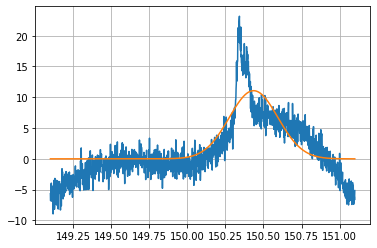

In [12]:
plt.plot(trunc_freq,trunc_spec)
plt.plot(trunc_freq, gaussian_val)
plt.grid()
plt.show

In [15]:
coords = np.array(dish.bubble_coords())

In [22]:
ν_0 = 150.4

bubble_T = []
bubble_v = []
bubble_σ = []

bubble_err = []


for i in trange(len(coords)):
    
    trunc_freq = freq[condition]
    trunc_spec = ctline_0[i, condition]
    
    gaussian_fit, cov = ugradio.gauss.gaussfit(x = trunc_freq, y = trunc_spec,
                                          amp = trunc_spec.max(),
                                          avg = trunc_freq[np.argmax(trunc_spec)],
                                          sig = 0.1,
                                          return_cov = True)
    
    T = gaussian_fit["amp"][0]
    bubble_T.append(T)
    
    err = np.sqrt(np.diag(cov))
    bubble_err.append(err)
    
    v_avg = (gaussian_fit["avg"][0]-ν_0)/ν_0 * c.c.value * 10**-3
    bubble_v.append(v_avg)
    
    σ = np.abs((gaussian_fit["sig"][0])/ν_0 * c.c.value * 10**-3)
    bubble_σ.append(σ)
    

100%|██████████| 697/697 [00:05<00:00, 126.78it/s]


In [21]:
np.sqrt(np.diag(cov)[0])

1.2036455684938314

In [34]:
T_err = np.array(bubble_err)[:, 0]
v_err = np.array(bubble_err)[:, 1]
σ_err = np.array(bubble_err)[:, 2]

l = coords[:,0]
b = coords[:,1]

In [35]:
df = pd.DataFrame({'T': bubble_T, 'v': bubble_v, 'σ': bubble_σ, 'T_err': T_err, 'v_err': v_err, 'σ_err': σ_err, 'l': l, 'b': b})

In [37]:
df.to_csv('final_data')